In [1237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


In [1238]:
#Read the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [1239]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Exploratory Data Analysis

In [1240]:
#Determine if there are any columns with NaN values
missing_cols = df_train.columns[df_train.isna().any()].tolist()
print("The columns with the missing data are the following: " + str(missing_cols))

The columns with the missing data are the following: ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


In [1241]:
# Almost all the columns have NaN values, so we need to determine the percentage of NaN values in each column
def count_nans(df):
    print("The percentage of NaN values in each column is the following: ")
    for col in df.columns:
        print(col, df[col].isna().sum()/len(df[col])*100)

count_nans(df_train)

The percentage of NaN values in each column is the following: 
PassengerId 0.0
HomePlanet 2.312205222592891
CryoSleep 2.4962613597147127
Cabin 2.289198205452663
Destination 2.093638559760727
Age 2.0591280340503855
VIP 2.3352122397331185
RoomService 2.082135051190613
FoodCourt 2.105142068330841
ShoppingMall 2.392729782583688
Spa 2.105142068330841
VRDeck 2.1626596111814105
Name 2.300701714022777
Transported 0.0


As we can see, almost all the columns have around 2% of missing values, which can be handled with imputation. 

In [1242]:
# Let's convert the type of the column "Transported" to integer from the bool type
df_train["Transported"] = df_train["Transported"].astype(int)

As can be seen from the data, the Cabin column contatins the cabin number in the deck/num/side format. Therefore, we can separate the data about deck and side into separate categorical columns. 

In [1243]:
# Configure the column Cabin. \d - any digit
def cabin_conf(input):
    input = str(input)
    cabin_conf_pattern = r"/\d+/"
    output = re.sub(cabin_conf_pattern, "/", input)

    return output

df_train["Cabin_conf"] = df_train["Cabin"].apply(cabin_conf)
df_test["Cabin_conf"] = df_test["Cabin"].apply(cabin_conf)

# Divide the data into two different columns 
df_train[['Cabin_Deck', 'Cabin_Side']] = df_train['Cabin_conf'].str.split('/', expand=True)
df_test[['Cabin_Deck', 'Cabin_Side']] = df_test['Cabin_conf'].str.split('/', expand=True)

df_train.drop(['Cabin', "Cabin_conf"], axis=1, inplace=True)
df_test.drop(['Cabin', "Cabin_conf"], axis=1, inplace=True)

df_train.sample(10)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Side
4296,4576_01,Earth,False,TRAPPIST-1e,37.0,False,661.0,876.0,0.0,3.0,13.0,Fayene Cartz,0,F,P
468,0504_03,Europa,True,NaN,24.0,False,0.0,0.0,0.0,0.0,0.0,Sterops Unpasine,1,B,S
75,0082_01,Mars,False,TRAPPIST-1e,42.0,False,7406.0,0.0,0.0,0.0,0.0,Totse Datte,0,F,P
3547,3811_01,Mars,True,TRAPPIST-1e,54.0,False,0.0,0.0,0.0,0.0,0.0,Fisps Frasp,1,F,P
1468,1551_01,Europa,False,TRAPPIST-1e,30.0,False,0.0,1376.0,43.0,0.0,1460.0,Skyrmak Clidly,1,E,P
6434,6788_01,Earth,False,TRAPPIST-1e,56.0,False,2.0,736.0,0.0,71.0,0.0,Glenna Weberton,0,G,P
3145,3392_03,Earth,True,TRAPPIST-1e,64.0,False,0.0,0.0,0.0,0.0,0.0,Ernard Gallard,1,G,S
2047,2193_01,Earth,False,PSO J318.5-22,25.0,False,0.0,0.0,619.0,0.0,70.0,Karlen Singtons,0,F,P
115,0120_01,Mars,True,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,NaN,Bees Sacre,1,F,P
5441,5812_01,Earth,True,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Holey Domington,1,G,S


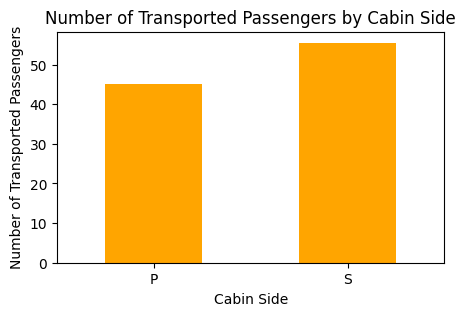

In [1244]:
cabin_side_transported = df_train.groupby('Cabin_Side')['Transported'].sum()
cabin_side_total = df_train["Cabin_Side"].value_counts()
cabin_side_percentage = cabin_side_transported / cabin_side_total * 100

plt.figure(figsize=(5, 3))
cabin_side_percentage.plot(kind='bar', color='orange')
plt.title('Number of Transported Passengers by Cabin Side')
plt.xlabel('Cabin Side')
plt.ylabel('Number of Transported Passengers')
plt.xticks(rotation=0)
plt.show()

As can be observed from the plot, the distribution between those who were transported is almost equal and do not depend much on the cabin side. However, the passengers from the cabin side S are more likely to be transported than not. 

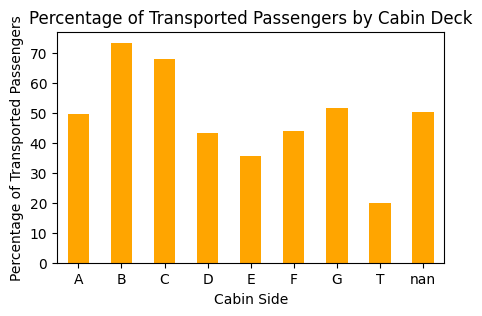

In [1245]:
cabin_deck_transported = df_train.groupby('Cabin_Deck')['Transported'].sum()
cabin_deck_total = df_train["Cabin_Deck"].value_counts()
cabin_deck_percentage = cabin_deck_transported / cabin_deck_total * 100

plt.figure(figsize=(5, 3))
cabin_deck_percentage.plot(kind='bar', color='orange')
plt.title('Percentage of Transported Passengers by Cabin Deck')
plt.xlabel('Cabin Side')
plt.ylabel('Percentage of Transported Passengers')
plt.xticks(rotation=0)
plt.show()

In [1246]:
df_train.drop(["VIP"], axis=1, inplace=True)
df_test.drop(["VIP"], axis=1, inplace=True)

### Age distribution

([<matplotlib.axis.XTick at 0x2983a49d0>,
 [Text(0.0, 0, '24.0'),
  Text(5.0, 0, '22.0'),
  Text(10.0, 0, '25.0'),
  Text(15.0, 0, '33.0'),
  Text(20.0, 0, '38.0'),
  Text(25.0, 0, '13.0'),
  Text(30.0, 0, '40.0'),
  Text(35.0, 0, '47.0'),
  Text(40.0, 0, '48.0'),
  Text(45.0, 0, '53.0'),
  Text(50.0, 0, '58.0'),
  Text(55.0, 0, '12.0'),
  Text(60.0, 0, '5.0'),
  Text(65.0, 0, '65.0'),
  Text(70.0, 0, '73.0'),
  Text(75.0, 0, '72.0')])

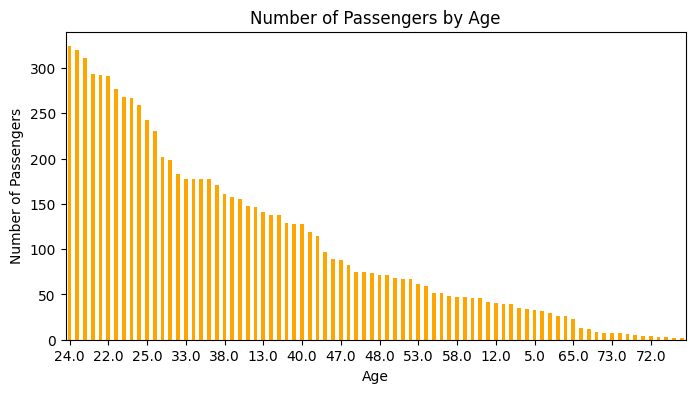

In [1247]:
# Calculate the total count of passengers for each age
age_total = df_train["Age"].value_counts()
unique_ages = df_train['Age'].unique()

plt.figure(figsize=(8, 4))
age_total.plot(kind='bar', color='orange')
plt.title('Number of Passengers by Age')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.xticks(np.arange(min(unique_ages), max(unique_ages)+1, 5), rotation=0)


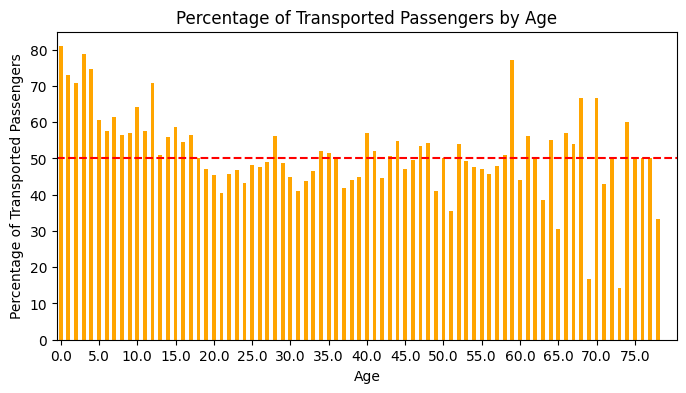

In [1248]:


# Group the data by Age and calculate the sum of the Transported column
transported_passengers = df_train[df_train['Transported'] == 1]
age_transported_count = transported_passengers['Age'].value_counts()

age_transported = pd.Series(0, index=unique_ages)
age_transported.update(age_transported_count)

age_total.sort_index(inplace=True)
age_transported.sort_index(inplace=True)

# Calculate the percentage of transported passengers by age
age_transported_percentage = age_transported / age_total * 100

# Create a stacked bar plot
plt.figure(figsize=(8, 4))
age_transported_percentage.plot(kind='bar', color='orange')
plt.axhline(y=50, color='red', linestyle='--', label='Y=50')
plt.title('Percentage of Transported Passengers by Age')
plt.xlabel('Age')
plt.ylabel('Percentage of Transported Passengers')
plt.xticks(np.arange(min(unique_ages), max(unique_ages)+1, 5), rotation=0)
plt.show()

It can be clearly seen from the plot that the minor aged passengers are more likely to be transported than not. On this basis, we can add a new feature which will show if the passenger is minor, youth from 19 to 27 or adult. 

In [1249]:
df_train["Is_minor"] = df_train["Age"].apply(lambda x: 1 if x < 18 else 0) # Applies this condition to every row
df_test["Is_minor"] = df_test["Age"].apply(lambda x: 1 if x < 18 else 0)

df_train["Is_youth"] = df_train["Age"].apply(lambda x: 1 if x > 18 and x <= 27 else 0)
df_test["Is_youth"] = df_test["Age"].apply(lambda x: 1 if x > 18 and x <= 27 else 0)

df_train["Is_adult"] = df_train["Age"].apply(lambda x: 1 if x > 27 and x <= 80 else 0)
df_test["Is_adult"] = df_test["Age"].apply(lambda x: 1 if x > 27 and x <= 80 else 0)


Plotting how many passengers spent something. 

In [1250]:
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_train['Spending_Sum'] = df_train[spending_columns].sum(axis=1)
df_test['Spending_Sum'] = df_test[spending_columns].sum(axis=1)


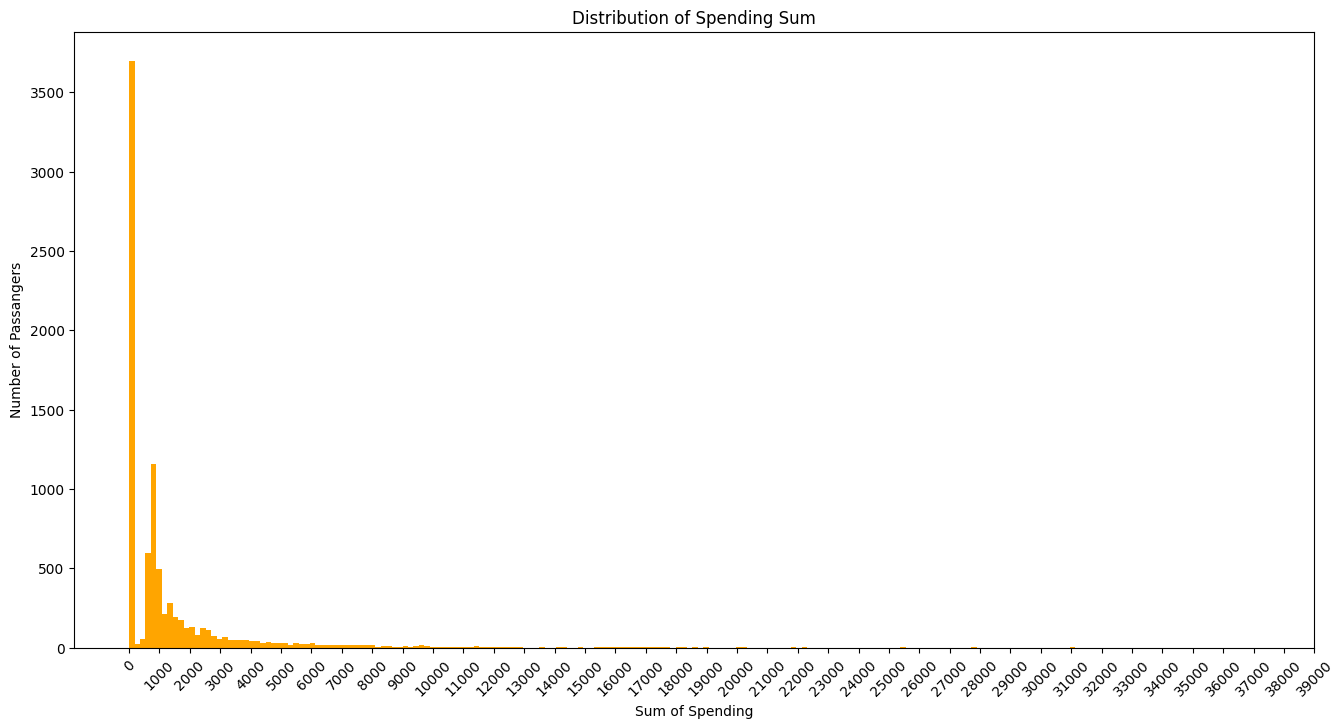

In [1251]:



plt.figure(figsize=(16, 8))
plt.hist(df_train['Spending_Sum'], bins=200, color='orange')
plt.title('Distribution of Spending Sum')
plt.xlabel('Sum of Spending')
plt.ylabel('Number of Passangers')

plt.xticks(range(0, 40000, 1000), rotation=45)  # Adjust the range and step size as needed

plt.show()

As can be observed from the histogram, most people didn't spent anything. Let's confinm it, finding the percentage of people who didn't spend anything:

In [1252]:
count_people = len(df_train["PassengerId"])
count_zero_spending = len(df_train[df_train["Spending_Sum"] == 0])

zero_spending_percentage = count_zero_spending / count_people * 100
print("Percent of people with 0 in Spending_Sum:", zero_spending_percentage)

Percent of people with 0 in Spending_Sum: 42.02231680662602


 Almost half of people have 0 as amount spent. Let's determine the if there is any link between spending and transportation.

/var/folders/6p/1jmnvrkx7jxdslfr99shm1z00000gn/T/ipykernel_15539/2255736631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transported_passengers['Spending_Sum'] = transported_passengers[spending_columns].sum(axis=1)
/var/folders/6p/1jmnvrkx7jxdslfr99shm1z00000gn/T/ipykernel_15539/2255736631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transported_passengers['Spending_Sum_Range'] = pd.cut(transported_passengers['Spending_Sum'], bins=bins) # Count transported passengers in each Spending_Sum range

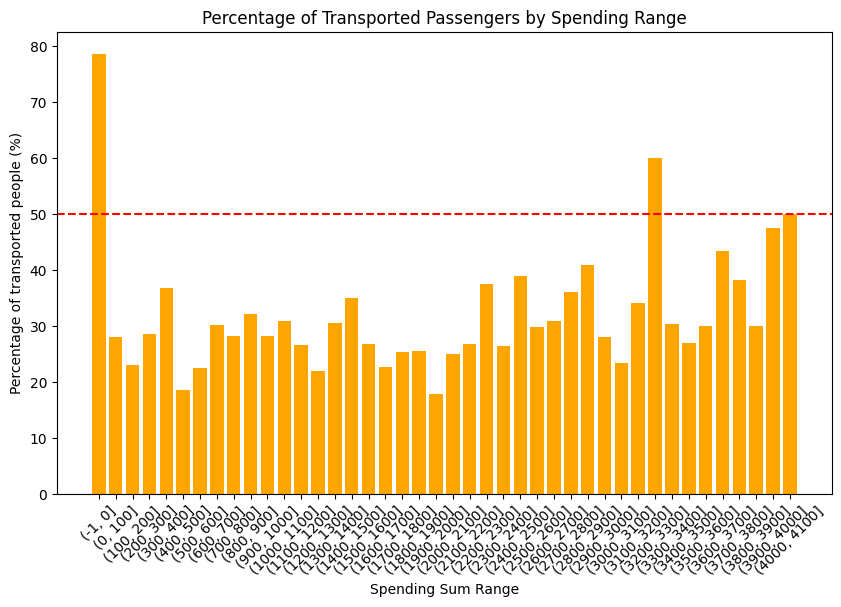

In [1253]:

transported_passengers = df_train[df_train['Transported'] == 1]
transported_passengers['Spending_Sum'] = transported_passengers[spending_columns].sum(axis=1)

bins = [-1] + list(range(0, 4200, 100))
df_train['Spending_Sum_Range'] = pd.cut(df_train['Spending_Sum'], bins=bins)# Use pd.cut to categorize Spending_Sum into bins
transported_passengers['Spending_Sum_Range'] = pd.cut(transported_passengers['Spending_Sum'], bins=bins) # Count transported passengers in each Spending_Sum range

count_by_range = df_train['Spending_Sum_Range'].value_counts().sort_index()
count_transported_by_range = transported_passengers['Spending_Sum_Range'].value_counts().sort_index()

# Create a DataFrame to store the counts
count_sum = pd.DataFrame({'Spending_Count': count_by_range, 'Spending_Count_Transported': count_transported_by_range})

# Calculate the percentage of people who were transported based on their spending range
count_sum['Transported_Spending_Percentage'] = (count_sum['Spending_Count_Transported'] / count_sum['Spending_Count']) * 100
count_sum.index = count_sum.index.astype(str) # Convert the ranges into strings so the matplotlib can read them 

# Display the result
plt.figure(figsize=(10, 6))
plt.bar(count_sum.index, count_sum['Transported_Spending_Percentage'], color='orange')
plt.axhline(y=50, color='red', linestyle='--', label='Y=50')
plt.title('Percentage of Transported Passengers by Spending Range')
plt.xlabel('Spending Sum Range')
plt.ylabel('Percentage of transported people (%)')
plt.xticks(rotation=45)
plt.show()


As can be observed from the graph, those who don't spend money on their journey are rather to be transported than not. Therefore, we can introduce additional book column "Expenditures".

In [1254]:
# Rewrite the Spending_Sum without the ranges
df_train['Spending_Sum'] = df_train[spending_columns].sum(axis=1)
df_test['Spending_Sum'] = df_test[spending_columns].sum(axis=1)

# df_train["Expenditures"] = df_train["Spending_Sum"].apply(lambda x: 1 if x > 0 else 0)
df_train.drop(["Spending_Sum_Range", "Spending_Sum"], axis=1, inplace=True)


# df_test["Expenditures"] = df_test["Spending_Sum"].apply(lambda x: 1 if x > 0 else 0)
df_test.drop(["Spending_Sum"], axis=1, inplace=True)

df_train.sample(10)


,PassengerId,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Side,Is_minor,Is_youth,Is_adult,Expenditures
1277,1353_02,Mars,False,TRAPPIST-1e,39.0,1535.0,0.0,340.0,0.0,723.0,Beant Tepie,0,F,S,0,0,1,1
6387,6749_01,Earth,False,TRAPPIST-1e,21.0,0.0,13.0,813.0,0.0,0.0,Luzel Barrelliver,1,G,P,0,1,0,1
2639,2822_02,Earth,NaN,TRAPPIST-1e,5.0,0.0,0.0,0.0,0.0,NaN,Salley Harverez,0,G,S,1,0,0,0
7953,8494_01,Mars,False,TRAPPIST-1e,42.0,770.0,0.0,1301.0,NaN,0.0,Cines Bota,1,E,P,0,0,1,1
6898,7306_01,Earth,False,55 Cancri e,26.0,1.0,0.0,0.0,0.0,718.0,Toniel Stroyledgez,1,E,P,0,1,0,1
6856,7250_01,Mars,False,55 Cancri e,51.0,40.0,716.0,1907.0,0.0,0.0,Pold Chmad,1,F,P,0,0,1,1
6969,7401_01,Mars,NaN,55 Cancri e,20.0,0.0,0.0,NaN,0.0,0.0,Diles Merte,0,E,P,0,1,0,0
7740,8260_03,Earth,True,55 Cancri e,4.0,0.0,0.0,0.0,0.0,0.0,Melara Daviddley,1,G,S,1,0,0,0
350,0384_01,Earth,False,55 Cancri e,0.0,0.0,0.0,0.0,0.0,0.0,Cliney Simpsonks,1,G,S,1,0,0,0
2224,2384_04,Earth,False,TRAPPIST-1e,4.0,0.0,0.0,0.0,0.0,0.0,Loreen Cleachrand,1,G,S,1,0,0,0


## Encoding 
Now, let's determine which columns are categorical and should be encoded. 

In [1255]:

nunique_cnt = df_train.nunique()
print(nunique_cnt)
low_card_cols = nunique_cnt[nunique_cnt < 10].index.tolist()
print("The following columns will be translated into categorical: " + str(low_card_cols))

low_card_cols.remove('Transported')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train[low_card_cols] = ordinal_encoder.fit_transform(df_train[low_card_cols])
df_test[low_card_cols] = ordinal_encoder.fit_transform(df_test[low_card_cols])

PassengerId     8693
HomePlanet         3
CryoSleep          2
Destination        3
Age               80
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
Cabin_Deck         9
Cabin_Side         2
Is_minor           2
Is_youth           2
Is_adult           2
Expenditures       2
dtype: int64
The following columns will be translated into categorical: ['HomePlanet', 'CryoSleep', 'Destination', 'Transported', 'Cabin_Deck', 'Cabin_Side', 'Is_minor', 'Is_youth', 'Is_adult', 'Expenditures']


In [1256]:
# Use imputer for ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']] columns

cols_impute_frequent = ['HomePlanet', 'CryoSleep', 'Destination', 'Cabin_Deck', 'Cabin_Side']

my_imputer = SimpleImputer(strategy='most_frequent')

X_train_imputed = df_train.copy()
X_test_imputed = df_test.copy()

X_train_imputed[cols_impute_frequent] = my_imputer.fit_transform(X_train_imputed[cols_impute_frequent])
X_test_imputed[cols_impute_frequent] = my_imputer.transform(X_test_imputed[cols_impute_frequent])

# X_train_imputed.columns = X_train.columns
# X_valid_imputed.columns = X_valid.columns
# X_test_imputed.columns = X_test.columns


df_train = X_train_imputed
df_test = X_test_imputed

count_nans(df_train)

print(df_train.sample(10))

The percentage of NaN values in each column is the following: 
PassengerId 0.0
HomePlanet 0.0
CryoSleep 0.0
Destination 0.0
Age 2.0591280340503855
RoomService 2.082135051190613
FoodCourt 2.105142068330841
ShoppingMall 2.392729782583688
Spa 2.105142068330841
VRDeck 2.1626596111814105
Name 2.300701714022777
Transported 0.0
Cabin_Deck 0.0
Cabin_Side 0.0
Is_minor 0.0
Is_youth 0.0
Is_adult 0.0
Expenditures 0.0
     PassengerId  HomePlanet  CryoSleep  Destination   Age  RoomService  \
4269     4544_01         0.0        1.0          2.0  34.0          0.0   
432      0463_02         2.0        0.0          2.0  14.0        928.0   
5493     5860_01         2.0        0.0          2.0  40.0          7.0   
5023     5367_01         1.0        1.0          2.0   4.0          0.0   
4026     4301_01         1.0        1.0          0.0  33.0          0.0   
1381     1452_04         1.0        0.0          2.0  33.0          0.0   
1416     1500_01         0.0        0.0          2.0  11.0        

In [1257]:
# Use imputer for money columns

cols_impute_mean = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "Age"]

my_imputer_mean = SimpleImputer(strategy='median')

X_train_imputed = df_train.copy()
X_test_imputed = df_test.copy()

X_train_imputed[cols_impute_mean] = my_imputer_mean.fit_transform(X_train_imputed[cols_impute_mean])
X_test_imputed[cols_impute_mean] = my_imputer_mean.transform(X_test_imputed[cols_impute_mean])

df_train = X_train_imputed
df_test = X_test_imputed

count_nans(df_train)

print(df_train.sample(10))

The percentage of NaN values in each column is the following: 
PassengerId 0.0
HomePlanet 0.0
CryoSleep 0.0
Destination 0.0
Age 0.0
RoomService 0.0
FoodCourt 0.0
ShoppingMall 0.0
Spa 0.0
VRDeck 0.0
Name 2.300701714022777
Transported 0.0
Cabin_Deck 0.0
Cabin_Side 0.0
Is_minor 0.0
Is_youth 0.0
Is_adult 0.0
Expenditures 0.0
     PassengerId  HomePlanet  CryoSleep  Destination   Age  RoomService  \
5770     6111_05         1.0        0.0          2.0  33.0          0.0   
5830     6172_01         0.0        1.0          2.0  36.0          0.0   
6098     6443_05         0.0        0.0          2.0  16.0         45.0   
1582     1674_01         0.0        1.0          1.0  20.0          0.0   
3075     3318_02         1.0        1.0          0.0  32.0          0.0   
362      0398_01         2.0        0.0          2.0  22.0         28.0   
1747     1860_02         1.0        0.0          0.0  35.0         95.0   
5025     5367_03         1.0        0.0          0.0  46.0          0.0   
81

In order to evaluate the performance of the model, let's define the MAE function.

In [1258]:
def mae(X_train, X_valid, y_train, y_valid, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, predictions)
    
    return accuracy

In [1259]:
df_train.drop(["Name"], axis=1, inplace=True)
df_test.drop(["Name"], axis=1, inplace=True)

df_test_predict = df_test.copy()
df_test_predict.drop(["PassengerId"], axis=1, inplace=True)
# Select the target
y = df_train.Transported
# Select the features
X = df_train.drop(['Transported', "PassengerId"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [1260]:
model_rfc = RandomForestClassifier(max_leaf_nodes=150, n_estimators=500)
print(mae(X_train, X_valid, y_train, y_valid, model_rfc))

model_rfc.fit(X_train, y_train)
predictions = model_rfc.predict(df_test_predict)

predictions = predictions.astype(bool)

0.7918343875790684


In [1261]:
# Create the model
# model = XGBRegressor(n_estimators=800,
#                          learning_rate=0.05) 
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': predictions})
output.to_csv('submission.csv', index=False)

print(len(output.index))

4277
